# Comparaison de LOF, OC-SVM et Isolation Forest

## Jeu de données

Nous utilisons le jeu de données KDD99CUP

## Métriques de comparaison

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from matplotlib.mlab import frange
import statistics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve


## Chargement du jeu de données KDD99-Cup HTTP

KDD99-Cup HTTP contient 30 attributs dont le dernier est la classe à expliquer.
Il y a 620098 observations dont 1052 anormales.
Avec le dernier attribut, nous avons les classes "o" pour les anomalies et "n" pour les observations normales.

In [2]:
data_brut_KDD99CUP = pd.read_csv('/Users/thesard/Doctorat/These2018/ISEP/Developpements/EspaceIntelliJ/LearningAllInPython/Learning_IHM_Features/datasets/imported_datasets/kdd99-unsupervised-ad_2019-06-24 16:08:29.815617.csv', header=None, index_col=None)
X_KDD99CUP = data_brut_KDD99CUP[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]]
y_brut_KDD99CUP = data_brut_KDD99CUP[[29]]
data_brut_KDD99CUP.describe()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
count,620098.000000,620098.000000,6.200980e+05,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,...,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000
mean,0.627670,280.374673,4.099298e+03,0.005012,0.912428,0.000947,0.000318,0.000013,0.000010,0.005409,...,127.698101,244.485422,0.996744,0.000796,0.074723,0.031820,0.001920,0.001473,0.087651,0.086732
std,53.972528,1509.901935,2.369388e+04,0.098271,0.282671,0.045654,0.017821,0.003592,0.003111,0.073346,...,105.897233,40.458619,0.033137,0.009522,0.185812,0.050689,0.030694,0.028037,0.274777,0.268543
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,210.000000,4.580000e+02,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,22.000000,255.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,240.000000,1.425000e+03,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,96.000000,255.000000,1.000000,0.000000,0.010000,0.020000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,302.000000,3.731000e+03,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,0.050000,0.040000,0.000000,0.000000,0.000000,0.000000
max,41065.000000,54540.000000,1.173059e+07,21.000000,1.000000,21.000000,1.000000,1.000000,1.000000,1.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
# Nombre d'anomalies
n_outliers = data_brut_KDD99CUP[data_brut_KDD99CUP[29] == 'o']
len(n_outliers)/6

175.33333333333334

In [4]:
#Pourcentage d'anomalies
pourcentage_anomalies = len(n_outliers)/len(data_brut_KDD99CUP)
pourcentage_anomalies

0.0016965060361426743

In [5]:
# Nombre de données normales
n_normals = data_brut_KDD99CUP[data_brut_KDD99CUP[29] == 'n']
len(n_normals)/6

103174.33333333333

In [6]:
#Pourcentage de données normales
pourcentage_normales = len(n_normals)/len(data_brut_KDD99CUP)
pourcentage_normales

0.9983034939638573

## Spliter le jeu de donner pour réduire la taille
Ceci sera fait en tenant compte du taux d'anomalies dans le jeu de données principale.
On aura au final 6 sous jeux de données sur lesquels chaque méthode sera appliquée. 
La moyenne des résultats sera alors le résultat à retenir pour tout le jeu de données.
NB: 
    - CPU Time = Somme
    - Précion  = Moyenne ou Somme des différentes matrices de confusion
    - Rappel   = Moyenne ou Somme des différentes matrices de confusion
    - ROC AUC  = Moyenne
    - f1-score = Moyenne
    - TNBC     = Moyenne ou Somme des différentes matrices de confusion
    - TPBC     = Moyenne ou Somme des différentes matrices de confusion

In [7]:
# Spliter à l'aide Stratifield mais ça ne donne pas le résultat que je veux. ça donne 6 jeux d'entrainement et
# et de test, tous de même taille dont la somme des jeux de test et d'entrainement donne la taille du jeu de 
# données original.
#from sklearn.model_selection import StratifiedShuffleSplit
#split = StratifiedShuffleSplit(n_splits=6, test_size=0.16965060361426743, random_state=42)
#i = 0
#for train_index, test_index in split.split(data_brut_KDD99CUP, data_brut_KDD99CUP[29]):
#    i=i+1
#    strat_train_set = data_brut_KDD99CUP.loc[train_index]
#    print("train :"+str(i))
#    #print(strat_train_set)
#    print("Taille ="+str(len(strat_train_set)))
#    strat_train_outliers = strat_train_set[strat_train_set[29] == 'o']
#    strat_train_normals  = strat_train_set[strat_train_set[29] == 'n']
#    print("n_outliers ="+str(len(strat_train_outliers)/(len(strat_train_outliers) + len(strat_train_normals))))
#    print("%_outliers ="+str(len(strat_train_outliers)))
#    print("n_normals  ="+str(len(strat_train_normals)))
#    print("%_normals  ="+str(len(strat_train_normals)/(len(strat_train_outliers) + len(strat_train_normals))))
#    strat_test_set = data_brut_KDD99CUP.loc[test_index]
#    print("test :"+str(i))
#    #print(strat_test_set)
#    print("Taille ="+str(len(strat_test_set)))
#    strat_test_outliers = strat_test_set[strat_test_set[29] == 'o']
#    strat_test_normals  = strat_test_set[strat_test_set[29] == 'n']
#    print("n_outliers ="+str(len(strat_test_outliers)))
#    print("%_outliers ="+str(len(strat_test_outliers)/(len(strat_test_outliers) + len(strat_test_normals))))
#    print("n_normals  ="+str(len(strat_test_normals)))
#    print("%_normals  ="+str(len(strat_test_normals)/(len(strat_test_outliers) + len(strat_test_normals))))
#    print("\n")

In [8]:
# Subset the dataset by myself
import math
n_i_min = 0
o_i_min = 0
n_i_max = math.ceil(len(n_normals)/6)
o_i_max = math.ceil(len(n_outliers)/6)
n_sub_dataset_1 = n_normals[n_i_min:n_i_max]
print("Length normals subset 1 = "+str(len(n_sub_dataset_1)))
o_sub_dataset_1 = n_outliers[o_i_min:o_i_max]
print("Length outliers subset 1 = "+str(len(o_sub_dataset_1)))

n_i_min = n_i_max
o_i_min = o_i_max
n_i_max = n_i_max + math.ceil(len(n_normals)/6)
o_i_max = o_i_max + math.ceil(len(n_outliers)/6)
n_sub_dataset_2 = n_normals[n_i_min:n_i_max]
print("Length normals subset 2 = "+str(len(n_sub_dataset_2)))
o_sub_dataset_2 = n_outliers[o_i_min:o_i_max]
print("Length outliers subset 2 = "+str(len(o_sub_dataset_2)))

n_i_min = n_i_max
o_i_min = o_i_max
n_i_max = n_i_max + math.ceil(len(n_normals)/6)
o_i_max = o_i_max + math.ceil(len(n_outliers)/6)
n_sub_dataset_3 = n_normals[n_i_min:n_i_max]
print("Length normals subset 3 = "+str(len(n_sub_dataset_3)))
o_sub_dataset_3 = n_outliers[o_i_min:o_i_max]
print("Length outliers subset 3 = "+str(len(o_sub_dataset_3)))

n_i_min = n_i_max
o_i_min = o_i_max
n_i_max = n_i_max + math.ceil(len(n_normals)/6)
o_i_max = o_i_max + math.ceil(len(n_outliers)/6)
n_sub_dataset_4 = n_normals[n_i_min:n_i_max]
print("Length normals subset 4 = "+str(len(n_sub_dataset_4)))
o_sub_dataset_4 = n_outliers[o_i_min:o_i_max]
print("Length outliers subset 4 = "+str(len(o_sub_dataset_4)))

n_i_min = n_i_max
o_i_min = o_i_max
n_i_max = n_i_max + math.ceil(len(n_normals)/6)
o_i_max = o_i_max + math.ceil(len(n_outliers)/6)
n_sub_dataset_5 = n_normals[n_i_min:n_i_max]
print("Length normals subset 5 = "+str(len(n_sub_dataset_5)))
o_sub_dataset_5 = n_outliers[o_i_min:o_i_max]
print("Length outliers subset 5 = "+str(len(o_sub_dataset_5)))

n_i_min = n_i_max
o_i_min = o_i_max
n_i_max = n_i_max + math.ceil(len(n_normals)/6)
o_i_max = o_i_max + math.ceil(len(n_outliers)/6)
n_sub_dataset_6 = n_normals[n_i_min:n_i_max]
print("Length normals subset 6 = "+str(len(n_sub_dataset_6)))
o_sub_dataset_6 = n_outliers[o_i_min:o_i_max]
print("Length outliers subset 6 = "+str(len(o_sub_dataset_6)))

Length normals subset 1 = 103175
Length outliers subset 1 = 176
Length normals subset 2 = 103175
Length outliers subset 2 = 176
Length normals subset 3 = 103175
Length outliers subset 3 = 176
Length normals subset 4 = 103175
Length outliers subset 4 = 176
Length normals subset 5 = 103175
Length outliers subset 5 = 176
Length normals subset 6 = 103171
Length outliers subset 6 = 172


## Fusion des deux sub_datasets (normales + anomalies)

In [9]:
# Fusion of the sub_datasets
sub_dataset_1 = n_sub_dataset_1.append(o_sub_dataset_1, ignore_index=True, sort=False)
sub_dataset_2 = n_sub_dataset_2.append(o_sub_dataset_2, ignore_index=True, sort=False)
sub_dataset_3 = n_sub_dataset_3.append(o_sub_dataset_3, ignore_index=True, sort=False)
sub_dataset_4 = n_sub_dataset_4.append(o_sub_dataset_4, ignore_index=True, sort=False)
sub_dataset_5 = n_sub_dataset_5.append(o_sub_dataset_5, ignore_index=True, sort=False)
sub_dataset_6 = n_sub_dataset_6.append(o_sub_dataset_6, ignore_index=True, sort=False)
#sub_dataset_6.describe()
# Détacher la classe à expliquer des autres classes
X_sub_dataset_1 = sub_dataset_1[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]]
y_sub_dataset_1 = sub_dataset_1[[29]]
X_sub_dataset_2 = sub_dataset_2[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]]
y_sub_dataset_2 = sub_dataset_2[[29]]
X_sub_dataset_3 = sub_dataset_3[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]]
y_sub_dataset_3 = sub_dataset_3[[29]]
X_sub_dataset_4 = sub_dataset_4[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]]
y_sub_dataset_4 = sub_dataset_4[[29]]
X_sub_dataset_5 = sub_dataset_5[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]]
y_sub_dataset_5 = sub_dataset_5[[29]]
X_sub_dataset_6 = sub_dataset_6[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]]
y_sub_dataset_6 = sub_dataset_6[[29]]


## Transformation de la classe à expliquer

L'objectif ici est de remplacer les "o" par -1 et les "n" par 1 afin de faire les matrices de confusion avec la fonction dédiée de scikit-learn.

In [10]:
y_transform_KDD99CUP      = y_brut_KDD99CUP
y_transform_KDD99CUP      = np.where(y_transform_KDD99CUP =='o',-1,1)
#y_transform_KDD99CUP

y_transform_sub_dataset_6 = np.where(y_sub_dataset_6 =='o',-1,1)
y_transform_sub_dataset_5 = np.where(y_sub_dataset_5 =='o',-1,1)
y_transform_sub_dataset_4 = np.where(y_sub_dataset_4 =='o',-1,1)
y_transform_sub_dataset_3 = np.where(y_sub_dataset_3 =='o',-1,1)
y_transform_sub_dataset_2 = np.where(y_sub_dataset_2 =='o',-1,1)
y_transform_sub_dataset_1 = np.where(y_sub_dataset_1 =='o',-1,1)

## KDD99CUP

### Exécution de Isolation Forest sur le jeux de données KDD99CUP.

In [11]:

max_samples = 'auto'

averages_executions_time_IF_KDD99CUP = []
averages_roc_auc_IF_KDD99CUP = []

for j in range(10, 300, 10):
    n_estimators = j
    executions_time_IF_KDD99CUP = []
    roc_auc_IF_KDD99CUP = []
    #for i in range(5):
###########################
    roc_auc_IF_Sub_Datasets = []
    start_IF_KDD99CUP = time()

    # Apply the function on the 6 sub_dataset
    func_IF_KDD99CUP = IsolationForest(n_estimators=n_estimators, max_samples=max_samples)
    func_IF_KDD99CUP.fit(X_sub_dataset_1)
    y_pred_IF_sub_dataset_1 = func_IF_KDD99CUP.predict(X_sub_dataset_1)

    func_IF_KDD99CUP = IsolationForest(n_estimators=n_estimators, max_samples=max_samples)
    func_IF_KDD99CUP.fit(X_sub_dataset_2)
    y_pred_IF_sub_dataset_2 = func_IF_KDD99CUP.predict(X_sub_dataset_2)

    func_IF_KDD99CUP = IsolationForest(n_estimators=n_estimators, max_samples=max_samples)
    func_IF_KDD99CUP.fit(X_sub_dataset_3)
    y_pred_IF_sub_dataset_3 = func_IF_KDD99CUP.predict(X_sub_dataset_3)

    func_IF_KDD99CUP = IsolationForest(n_estimators=n_estimators, max_samples=max_samples)
    func_IF_KDD99CUP.fit(X_sub_dataset_4)
    y_pred_IF_sub_dataset_4 = func_IF_KDD99CUP.predict(X_sub_dataset_4)

    func_IF_KDD99CUP = IsolationForest(n_estimators=n_estimators, max_samples=max_samples)
    func_IF_KDD99CUP.fit(X_sub_dataset_5)
    y_pred_IF_sub_dataset_5 = func_IF_KDD99CUP.predict(X_sub_dataset_5)

    func_IF_KDD99CUP = IsolationForest(n_estimators=n_estimators, max_samples=max_samples)
    func_IF_KDD99CUP.fit(X_sub_dataset_6)
    y_pred_IF_sub_dataset_6 = func_IF_KDD99CUP.predict(X_sub_dataset_6)

    # Calcul du temps d'exécution
    exec_time_IF_KDD99CUP = time() - start_IF_KDD99CUP
    executions_time_IF_KDD99CUP.append(exec_time_IF_KDD99CUP)

    # Calcul de l'aire sous la courbe ROC
    # Apply the function on ROC AUC on the 6 sub_dataset
    auc_IF_KDD99CUP = roc_auc_score(y_transform_sub_dataset_1, y_pred_IF_sub_dataset_1)
    roc_auc_IF_Sub_Datasets.append(auc_IF_KDD99CUP)
    auc_IF_KDD99CUP = roc_auc_score(y_transform_sub_dataset_2, y_pred_IF_sub_dataset_2)
    roc_auc_IF_Sub_Datasets.append(auc_IF_KDD99CUP)
    auc_IF_KDD99CUP = roc_auc_score(y_transform_sub_dataset_3, y_pred_IF_sub_dataset_3)
    roc_auc_IF_Sub_Datasets.append(auc_IF_KDD99CUP)
    auc_IF_KDD99CUP = roc_auc_score(y_transform_sub_dataset_4, y_pred_IF_sub_dataset_4)
    roc_auc_IF_Sub_Datasets.append(auc_IF_KDD99CUP)
    auc_IF_KDD99CUP = roc_auc_score(y_transform_sub_dataset_5, y_pred_IF_sub_dataset_5)
    roc_auc_IF_Sub_Datasets.append(auc_IF_KDD99CUP)
    auc_IF_KDD99CUP = roc_auc_score(y_transform_sub_dataset_6, y_pred_IF_sub_dataset_6)
    roc_auc_IF_Sub_Datasets.append(auc_IF_KDD99CUP)

    # Mean of the ROC AUC of the 6 sub_datasets
    roc_auc_IF_KDD99CUP.append(statistics.mean(roc_auc_IF_Sub_Datasets))
    #print("ROC AUC for Isolation Forest applied on KDD99CUP")
    #print(roc_auc_IF_KDD99CUP)
 #######################################       
    print("Execution time of IsolationForest applied on KDD99CUP (in second)")
    print(executions_time_IF_KDD99CUP)
    print("ROC AUC for Isolation Forest applied on KDD99CUP")
    print(roc_auc_IF_KDD99CUP)
    averages_executions_time_IF_KDD99CUP.append(statistics.mean(executions_time_IF_KDD99CUP))
    averages_roc_auc_IF_KDD99CUP.append(statistics.mean(roc_auc_IF_KDD99CUP))

/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[5.474315166473389]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9105175438635321]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[11.751786947250366]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9493183441602028]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[17.68907904624939]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.8909750018493129]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[21.477853059768677]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.8841788363052995]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[26.498064756393433]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.8996645154498808]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[38.772053956985474]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.930639908145468]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[39.88330101966858]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9020265808633255]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[51.27573084831238]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.946904155280776]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[60.63137626647949]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9151714068259281]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[66.43341588973999]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9449857702055114]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[73.22292113304138]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9393815425189638]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[84.09044122695923]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9328523664026407]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[91.03925085067749]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9402318335217903]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[90.27614498138428]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9050018336988779]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[101.24819612503052]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9355557837066101]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[131.7983808517456]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9189657471274164]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[111.2269778251648]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9292892635452279]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[128.85357809066772]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9030334532611207]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[126.88310503959656]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9378603708333602]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[118.67594313621521]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9083024969218515]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[142.6133360862732]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9329412645467278]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[142.9195671081543]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9134544548096931]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[147.50535488128662]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9190428262754418]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[147.04211926460266]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9121825046106222]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[152.53202891349792]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9440970877996503]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[158.2925250530243]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9391951580228469]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[162.89157581329346]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9401429353777032]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[173.8621859550476]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9295543412525599]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on KDD99CUP (in second)
[178.1702229976654]
ROC AUC for Isolation Forest applied on KDD99CUP
[0.9373081914584477]


### Résultat de Isolation Forest sur KDD99CUP

Execution time of IsolationForest applied on KDD99CUP (in second)
[5.474315166473389, 11.751786947250366, 17.68907904624939, 21.477853059768677, 26.498064756393433, 38.772053956985474, 39.88330101966858, 51.27573084831238, 60.63137626647949, 66.43341588973999, 73.22292113304138, 84.09044122695923, 91.03925085067749, 90.27614498138428, 101.24819612503052, 131.7983808517456, 111.2269778251648, 128.85357809066772, 126.88310503959656, 118.67594313621521, 142.6133360862732, 142.9195671081543, 147.50535488128662, 147.04211926460266, 152.53202891349792, 158.2925250530243, 162.89157581329346, 173.8621859550476, 178.1702229976654]


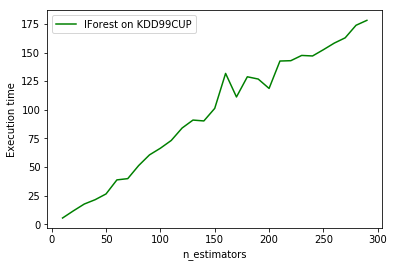

In [13]:
print("Execution time of IsolationForest applied on KDD99CUP (in second)")
print(averages_executions_time_IF_KDD99CUP)
plt.plot(range(10, 300, 10), averages_executions_time_IF_KDD99CUP,  "g-", label="IForest on KDD99CUP")
#plt.axis([0, 1, 0, 1])
plt.xlabel('n_estimators')
plt.ylabel('Execution time')
plt.legend(loc="best")
plt.show()

ROC AUC for Isolation Forest applied on KDD99CUP
[0.9105175438635321, 0.9493183441602028, 0.8909750018493129, 0.8841788363052995, 0.8996645154498808, 0.930639908145468, 0.9020265808633255, 0.946904155280776, 0.9151714068259281, 0.9449857702055114, 0.9393815425189638, 0.9328523664026407, 0.9402318335217903, 0.9050018336988779, 0.9355557837066101, 0.9189657471274164, 0.9292892635452279, 0.9030334532611207, 0.9378603708333602, 0.9083024969218515, 0.9329412645467278, 0.9134544548096931, 0.9190428262754418, 0.9121825046106222, 0.9440970877996503, 0.9391951580228469, 0.9401429353777032, 0.9295543412525599, 0.9373081914584477]
La valeur max est 0.9493183441602028 à l'index 1


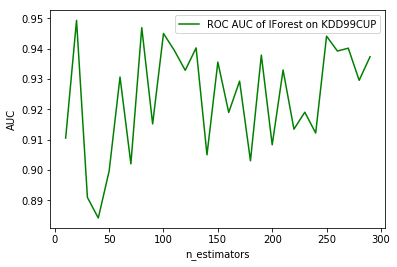

In [14]:
print("ROC AUC for Isolation Forest applied on KDD99CUP")
print(averages_roc_auc_IF_KDD99CUP)
print("La valeur max est "+str(max(averages_roc_auc_IF_KDD99CUP))+" à l'index "+str(averages_roc_auc_IF_KDD99CUP.index(max(averages_roc_auc_IF_KDD99CUP))))
plt.plot(range(10, 300, 10), averages_roc_auc_IF_KDD99CUP,  "g-", label="ROC AUC of IForest on KDD99CUP")
#plt.axis([0, 1, 0, 1])
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.legend(loc="best")
plt.show()

### Interprétation du résultat de IsolationForest sur KDD99CUP

Avec n_estimators entre 10 et 300, on remarque que le temps d'exécution augmente au fur et à mesure que le nombre d'estimateurs augmente. Concernant la performance, la meilleure estimation a été obtenu pour un taux de AUC = 0.9493183441602028 avec n_estimators = 20 ===> (10+1*10)
A noter que quelque soit la valeur de n_estimators, la AUC est toujours supérieure à 0,88

### Exécution de LOF sur KDD99CUP

In [16]:
averages_executions_time_LOF_KDD99CUP = []
averages_roc_auc_LOF_KDD99CUP = []

for j in range(5, 200, 5):
    n_neighbors = j
    executions_time_LOF_KDD99CUP = []
    roc_auc_LOF_KDD99CUP = []
        
    #for i in range(5):
###########################
    roc_auc_LOF_Sub_Datasets = []
    start_LOF_KDD99CUP = time()

    # Apply the function on the 6 sub_dataset
    func_LOF_KDD99CUP = LocalOutlierFactor(n_neighbors=n_neighbors,novelty=True)
    func_LOF_KDD99CUP.fit(X_sub_dataset_1)
    y_pred_LOF_sub_dataset_1 = func_LOF_KDD99CUP.predict(X_sub_dataset_1)

    func_LOF_KDD99CUP = LocalOutlierFactor(n_neighbors=n_neighbors,novelty=True)
    func_LOF_KDD99CUP.fit(X_sub_dataset_2)
    y_pred_LOF_sub_dataset_2 = func_LOF_KDD99CUP.predict(X_sub_dataset_2)

    func_LOF_KDD99CUP = LocalOutlierFactor(n_neighbors=n_neighbors,novelty=True)
    func_LOF_KDD99CUP.fit(X_sub_dataset_3)
    y_pred_LOF_sub_dataset_3 = func_LOF_KDD99CUP.predict(X_sub_dataset_3)

    func_LOF_KDD99CUP = LocalOutlierFactor(n_neighbors=n_neighbors,novelty=True)
    func_LOF_KDD99CUP.fit(X_sub_dataset_4)
    y_pred_LOF_sub_dataset_4 = func_LOF_KDD99CUP.predict(X_sub_dataset_4)

    func_LOF_KDD99CUP = LocalOutlierFactor(n_neighbors=n_neighbors,novelty=True)
    func_LOF_KDD99CUP.fit(X_sub_dataset_5)
    y_pred_LOF_sub_dataset_5 = func_LOF_KDD99CUP.predict(X_sub_dataset_5)

    func_LOF_KDD99CUP = LocalOutlierFactor(n_neighbors=n_neighbors,novelty=True)
    func_LOF_KDD99CUP.fit(X_sub_dataset_6)
    y_pred_LOF_sub_dataset_6 = func_LOF_KDD99CUP.predict(X_sub_dataset_6)

    # Calcul du temps d'exécution
    exec_time_LOF_KDD99CUP = time() - start_LOF_KDD99CUP
    executions_time_LOF_KDD99CUP.append(exec_time_LOF_KDD99CUP)

    # Calcul de l'aire sous la courbe ROC
    # Apply the function on ROC AUC on the 6 sub_dataset
    auc_LOF_KDD99CUP = roc_auc_score(y_transform_sub_dataset_1, y_pred_LOF_sub_dataset_1)
    roc_auc_LOF_Sub_Datasets.append(auc_LOF_KDD99CUP)
    auc_LOF_KDD99CUP = roc_auc_score(y_transform_sub_dataset_2, y_pred_LOF_sub_dataset_2)
    roc_auc_LOF_Sub_Datasets.append(auc_LOF_KDD99CUP)
    auc_LOF_KDD99CUP = roc_auc_score(y_transform_sub_dataset_3, y_pred_LOF_sub_dataset_3)
    roc_auc_LOF_Sub_Datasets.append(auc_LOF_KDD99CUP)
    auc_LOF_KDD99CUP = roc_auc_score(y_transform_sub_dataset_4, y_pred_LOF_sub_dataset_4)
    roc_auc_LOF_Sub_Datasets.append(auc_LOF_KDD99CUP)
    auc_LOF_KDD99CUP = roc_auc_score(y_transform_sub_dataset_5, y_pred_LOF_sub_dataset_5)
    roc_auc_LOF_Sub_Datasets.append(auc_LOF_KDD99CUP)
    auc_LOF_KDD99CUP = roc_auc_score(y_transform_sub_dataset_6, y_pred_LOF_sub_dataset_6)
    roc_auc_LOF_Sub_Datasets.append(auc_LOF_KDD99CUP)

    # Mean of the ROC AUC of the 6 sub_datasets
    roc_auc_LOF_KDD99CUP.append(statistics.mean(roc_auc_LOF_Sub_Datasets))
 #######################################  
        
    print("Execution time of LOF applied on KDD99CUP (in second)")
    print(executions_time_LOF_KDD99CUP)
    print("ROC AUC for LOF applied on KDD99CUP")
    print(roc_auc_LOF_KDD99CUP)
    averages_executions_time_LOF_KDD99CUP.append(statistics.mean(executions_time_LOF_KDD99CUP))
    averages_roc_auc_LOF_KDD99CUP.append(statistics.mean(roc_auc_LOF_KDD99CUP))


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[119.96337008476257]
ROC AUC for LOF applied on KDD99CUP
[0.5024380483717172]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[138.42904090881348]
ROC AUC for LOF applied on KDD99CUP
[0.5103569304840142]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[126.64919304847717]
ROC AUC for LOF applied on KDD99CUP
[0.5011774081713385]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[136.7086570262909]
ROC AUC for LOF applied on KDD99CUP
[0.5056516843530212]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[161.80929112434387]
ROC AUC for LOF applied on KDD99CUP
[0.5302490143883061]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[180.81040000915527]
ROC AUC for LOF applied on KDD99CUP
[0.5447519526374093]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[206.66056394577026]
ROC AUC for LOF applied on KDD99CUP
[0.5528915350038056]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[204.35635709762573]
ROC AUC for LOF applied on KDD99CUP
[0.5553818230769334]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[213.7025158405304]
ROC AUC for LOF applied on KDD99CUP
[0.5507759551454945]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[218.9968798160553]
ROC AUC for LOF applied on KDD99CUP
[0.5471538263909099]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[225.1395378112793]
ROC AUC for LOF applied on KDD99CUP
[0.5492910574573768]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[233.59887385368347]
ROC AUC for LOF applied on KDD99CUP
[0.5496135037676319]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[215.25695490837097]
ROC AUC for LOF applied on KDD99CUP
[0.5576223607610625]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[218.91902804374695]
ROC AUC for LOF applied on KDD99CUP
[0.5589935476744003]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[225.79934000968933]
ROC AUC for LOF applied on KDD99CUP
[0.558438486279224]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[239.14074206352234]
ROC AUC for LOF applied on KDD99CUP
[0.5512489835253117]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[287.5288472175598]
ROC AUC for LOF applied on KDD99CUP
[0.5558303680244185]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[299.9650979042053]
ROC AUC for LOF applied on KDD99CUP
[0.5528820362697504]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[249.74805402755737]
ROC AUC for LOF applied on KDD99CUP
[0.5452812406419016]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[278.19613003730774]
ROC AUC for LOF applied on KDD99CUP
[0.5428605073777839]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[315.5236818790436]
ROC AUC for LOF applied on KDD99CUP
[0.5324115339885632]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[312.7112991809845]
ROC AUC for LOF applied on KDD99CUP
[0.5289824469300162]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[305.580739736557]
ROC AUC for LOF applied on KDD99CUP
[0.5251315672258047]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[341.20323514938354]
ROC AUC for LOF applied on KDD99CUP
[0.5189584957533108]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[299.54203605651855]
ROC AUC for LOF applied on KDD99CUP
[0.5127991553416975]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[360.7555990219116]
ROC AUC for LOF applied on KDD99CUP
[0.5079972684339478]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[329.83745098114014]
ROC AUC for LOF applied on KDD99CUP
[0.5041690045284029]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[3380.440472841263]
ROC AUC for LOF applied on KDD99CUP
[0.49702392367848974]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[452.81019592285156]
ROC AUC for LOF applied on KDD99CUP
[0.4969811164326577]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[924.4491829872131]
ROC AUC for LOF applied on KDD99CUP
[0.4879469423866415]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[3515.1892080307007]
ROC AUC for LOF applied on KDD99CUP
[0.48554801776433726]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[344.56605100631714]
ROC AUC for LOF applied on KDD99CUP
[0.5414878839686843]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[672.387913942337]
ROC AUC for LOF applied on KDD99CUP
[0.5405061829158279]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[519.2939920425415]
ROC AUC for LOF applied on KDD99CUP
[0.541935522606158]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[358.3116819858551]
ROC AUC for LOF applied on KDD99CUP
[0.6244228514635668]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[366.6142020225525]
ROC AUC for LOF applied on KDD99CUP
[0.6258489598021151]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[382.76457810401917]
ROC AUC for LOF applied on KDD99CUP
[0.6258408835363949]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[391.9200439453125]
ROC AUC for LOF applied on KDD99CUP
[0.7126453021070644]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on KDD99CUP (in second)
[405.32807874679565]
ROC AUC for LOF applied on KDD99CUP
[0.7595881489080878]


### Résultat de LOF sur KDD99CUP

Execution time of LOF applied on KDD99CUP (in second)
[119.96337008476257, 138.42904090881348, 126.64919304847717, 136.7086570262909, 161.80929112434387, 180.81040000915527, 206.66056394577026, 204.35635709762573, 213.7025158405304, 218.9968798160553, 225.1395378112793, 233.59887385368347, 215.25695490837097, 218.91902804374695, 225.79934000968933, 239.14074206352234, 287.5288472175598, 299.9650979042053, 249.74805402755737, 278.19613003730774, 315.5236818790436, 312.7112991809845, 305.580739736557, 341.20323514938354, 299.54203605651855, 360.7555990219116, 329.83745098114014, 3380.440472841263, 452.81019592285156, 924.4491829872131, 3515.1892080307007, 344.56605100631714, 672.387913942337, 519.2939920425415, 358.3116819858551, 366.6142020225525, 382.76457810401917, 391.9200439453125, 405.32807874679565]


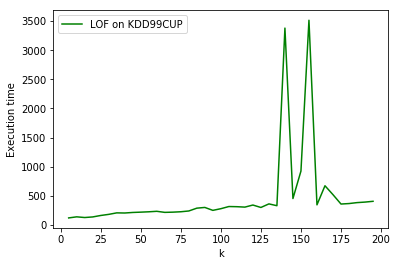

In [17]:
print("Execution time of LOF applied on KDD99CUP (in second)")
print(averages_executions_time_LOF_KDD99CUP)
plt.plot(range(5, 200, 5), averages_executions_time_LOF_KDD99CUP,  "g-", label="LOF on KDD99CUP")
#plt.axis([0, 200, 0, 200])
plt.xlabel('k')
plt.ylabel('Execution time')
plt.legend(loc="best")
plt.show()

ROC AUC for LOF applied on KDD99CUP
[0.5024380483717172, 0.5103569304840142, 0.5011774081713385, 0.5056516843530212, 0.5302490143883061, 0.5447519526374093, 0.5528915350038056, 0.5553818230769334, 0.5507759551454945, 0.5471538263909099, 0.5492910574573768, 0.5496135037676319, 0.5576223607610625, 0.5589935476744003, 0.558438486279224, 0.5512489835253117, 0.5558303680244185, 0.5528820362697504, 0.5452812406419016, 0.5428605073777839, 0.5324115339885632, 0.5289824469300162, 0.5251315672258047, 0.5189584957533108, 0.5127991553416975, 0.5079972684339478, 0.5041690045284029, 0.49702392367848974, 0.4969811164326577, 0.4879469423866415, 0.48554801776433726, 0.5414878839686843, 0.5405061829158279, 0.541935522606158, 0.6244228514635668, 0.6258489598021151, 0.6258408835363949, 0.7126453021070644, 0.7595881489080878]
La valeur max est 0.7595881489080878 à l'index 38


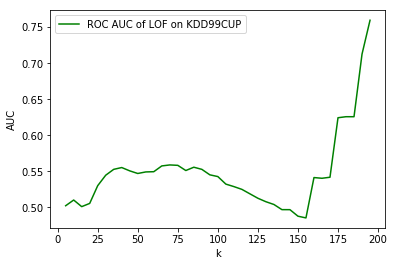

In [18]:
print("ROC AUC for LOF applied on KDD99CUP")
print(averages_roc_auc_LOF_KDD99CUP)
print("La valeur max est "+str(max(averages_roc_auc_LOF_KDD99CUP))+" à l'index "+str(averages_roc_auc_LOF_KDD99CUP.index(max(averages_roc_auc_LOF_KDD99CUP))))
plt.plot(range(5, 200, 5), averages_roc_auc_LOF_KDD99CUP,  "g-", label="ROC AUC of LOF on KDD99CUP")
#plt.axis([0, 1, 0, 1])
plt.xlabel('k')
plt.ylabel('AUC')
plt.legend(loc="best")
plt.show()

### Interprétation du résultat de LOF sur KDD99CUP

Plus le nombre de n_neighbors augmente, plus de temps d'éxécution est important. Ceci s'explique par le fait que plus le nombre de voisins à considérer est grand plus il faudra calculer les distances et les densité afin d'estimer le degré d'abberrance d'une observation.
Concernant la performance de la méthode, elle atteint son plus fort (AUC = 0.7595881489080878) à taux à n_neighbors= 195 ((38+1)*5) pour un temps d'exécution de 405.32807874679565
NB: Continuer l'expérience en prenant n_neighbors à partir de 200 jusqu'à 400 pour voir si ça continuera à mieux classer. 

### Exécution de OC-SVM sur KDD99CUP

In [ ]:
averages_executions_time_OCSVM_KDD99CUP = []
averages_roc_auc_OCSVM_KDD99CUP = []

for j in frange(0.1, 1., 0.1):
    nu = j
    executions_time_OCSVM_KDD99CUP = []
    roc_auc_OCSVM_KDD99CUP = []
    
    #for i in range(5):
###########################
    roc_auc_OCSVM_Sub_Datasets = []
    start_OCSVM_KDD99CUP = time()

    # Apply the function on the 6 sub_dataset
    func_OCSVM_KDD99CUP = OneClassSVM(nu=nu)
    func_OCSVM_KDD99CUP.fit(X_sub_dataset_1)
    y_pred_OCSVM_sub_dataset_1 = func_OCSVM_KDD99CUP.predict(X_sub_dataset_1)

    func_OCSVM_KDD99CUP = OneClassSVM(nu=nu)
    func_OCSVM_KDD99CUP.fit(X_sub_dataset_2)
    y_pred_OCSVM_sub_dataset_2 = func_OCSVM_KDD99CUP.predict(X_sub_dataset_2)

    func_OCSVM_KDD99CUP = OneClassSVM(nu=nu)
    func_OCSVM_KDD99CUP.fit(X_sub_dataset_3)
    y_pred_OCSVM_sub_dataset_3 = func_OCSVM_KDD99CUP.predict(X_sub_dataset_3)

    func_OCSVM_KDD99CUP = OneClassSVM(nu=nu)
    func_OCSVM_KDD99CUP.fit(X_sub_dataset_4)
    y_pred_OCSVM_sub_dataset_4 = func_OCSVM_KDD99CUP.predict(X_sub_dataset_4)

    func_OCSVM_KDD99CUP = OneClassSVM(nu=nu)
    func_OCSVM_KDD99CUP.fit(X_sub_dataset_5)
    y_pred_OCSVM_sub_dataset_5 = func_OCSVM_KDD99CUP.predict(X_sub_dataset_5)

    func_OCSVM_KDD99CUP = OneClassSVM(nu=nu)
    func_OCSVM_KDD99CUP.fit(X_sub_dataset_6)
    y_pred_OCSVM_sub_dataset_6 = func_OCSVM_KDD99CUP.predict(X_sub_dataset_6)

    # Calcul du temps d'exécution
    exec_time_OCSVM_KDD99CUP = time() - start_OCSVM_KDD99CUP
    executions_time_OCSVM_KDD99CUP.append(exec_time_OCSVM_KDD99CUP)

    # Calcul de l'aire sous la courbe ROC
    # Apply the function on ROC AUC on the 6 sub_dataset
    auc_OCSVM_KDD99CUP = roc_auc_score(y_transform_sub_dataset_1, y_pred_OCSVM_sub_dataset_1)
    roc_auc_OCSVM_Sub_Datasets.append(auc_OCSVM_KDD99CUP)
    auc_OCSVM_KDD99CUP = roc_auc_score(y_transform_sub_dataset_2, y_pred_OCSVM_sub_dataset_2)
    roc_auc_OCSVM_Sub_Datasets.append(auc_OCSVM_KDD99CUP)
    auc_OCSVM_KDD99CUP = roc_auc_score(y_transform_sub_dataset_3, y_pred_OCSVM_sub_dataset_3)
    roc_auc_OCSVM_Sub_Datasets.append(auc_OCSVM_KDD99CUP)
    auc_OCSVM_KDD99CUP = roc_auc_score(y_transform_sub_dataset_4, y_pred_OCSVM_sub_dataset_4)
    roc_auc_OCSVM_Sub_Datasets.append(auc_OCSVM_KDD99CUP)
    auc_OCSVM_KDD99CUP = roc_auc_score(y_transform_sub_dataset_5, y_pred_OCSVM_sub_dataset_5)
    roc_auc_OCSVM_Sub_Datasets.append(auc_OCSVM_KDD99CUP)
    auc_OCSVM_KDD99CUP = roc_auc_score(y_transform_sub_dataset_6, y_pred_OCSVM_sub_dataset_6)
    roc_auc_OCSVM_Sub_Datasets.append(auc_OCSVM_KDD99CUP)

    # Mean of the ROC AUC of the 6 sub_datasets
    roc_auc_OCSVM_KDD99CUP.append(statistics.mean(roc_auc_OCSVM_Sub_Datasets))
 #######################################  
        
    print("Execution time of OC-SVM applied on KDD99CUP (in second)")
    print(executions_time_OCSVM_KDD99CUP)
    print("ROC AUC for OC-SVM applied on KDD99CUP")
    print(roc_auc_OCSVM_KDD99CUP)
    averages_executions_time_OCSVM_KDD99CUP.append(statistics.mean(executions_time_OCSVM_KDD99CUP))
    averages_roc_auc_OCSVM_KDD99CUP.append(statistics.mean(roc_auc_OCSVM_KDD99CUP))

/Users/thesard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: numpy.arange
  after removing the cwd from sys.path.
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled fea

Execution time of OC-SVM applied on KDD99CUP (in second)
[18384.637491941452]
ROC AUC for OC-SVM applied on KDD99CUP
[0.4675138919100333]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packa

Execution time of OC-SVM applied on KDD99CUP (in second)
[45283.88564300537]
ROC AUC for OC-SVM applied on KDD99CUP
[0.4752688021446837]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packa

Execution time of OC-SVM applied on KDD99CUP (in second)
[27914.666049957275]
ROC AUC for OC-SVM applied on KDD99CUP
[0.5085514346304281]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packa

Execution time of OC-SVM applied on KDD99CUP (in second)
[25656.773991823196]
ROC AUC for OC-SVM applied on KDD99CUP
[0.47062357835299534]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packa

Execution time of OC-SVM applied on KDD99CUP (in second)
[37914.47582697868]
ROC AUC for OC-SVM applied on KDD99CUP
[0.4451613993418523]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packa

Execution time of OC-SVM applied on KDD99CUP (in second)
[50249.34791183472]
ROC AUC for OC-SVM applied on KDD99CUP
[0.4706808063751264]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packa

Execution time of OC-SVM applied on KDD99CUP (in second)
[34326.43030381203]
ROC AUC for OC-SVM applied on KDD99CUP
[0.5257938302709084]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packa

Execution time of OC-SVM applied on KDD99CUP (in second)
[10696.318743228912]
ROC AUC for OC-SVM applied on KDD99CUP
[0.4623031718518739]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packa

Execution time of OC-SVM applied on KDD99CUP (in second)
[8129.58048915863]
ROC AUC for OC-SVM applied on KDD99CUP
[0.4878367715789079]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packa

### Résultat de OC-SVM sur KDD99CUP

In [ ]:
print("Execution time of OC-SVM applied on KDD99CUP (in second)")
print(averages_executions_time_OCSVM_KDD99CUP)
plt.plot(frange(0.1, 1., 0.1), averages_executions_time_OCSVM_KDD99CUP,  "g-", label="OC-SVM on KDD99CUP")
#plt.axis([0, 1, 0, 1])
plt.xlabel('nu')
plt.ylabel('Execution time')
plt.legend(loc="best")
plt.show()

In [ ]:
print("ROC AUC for OC-SVM applied on KDD99CUP")
print(averages_roc_auc_OCSVM_KDD99CUP)
plt.plot(frange(0.1, 1., 0.1), averages_roc_auc_OCSVM_KDD99CUP,  "g-", label="ROC AUC of OCSVM on KDD99CUP")
#plt.axis([0, 1, 0, 1])
plt.xlabel('nu')
plt.ylabel('AUC')
plt.legend(loc="best")
plt.show()

### Interprétation du résultat de OC-SVM sur KDD99CUP

Plus la valeur de nu augmente plus le temps d'exécution diminue. OC-SVM est donc plus rapide sur KDD99CUP avec un nu plus grand.
Mais, celà n'entraîne pas un bon résultat de la méthode. Puisqu'à partir d'un nu de 0.5, la prédiction de l'algorithme devient de plus en plus aléatoire. La meilleure performance est atteinte à nu= 0.4

## Exécution des méthodes avec les meilleurs paramètres trouvés sur KDD99CUP

In [ ]:
executions_time_KDD99CUP = []
precisions_KDD99CUP = []
recalls_KDD99CUP = []
roc_aucs_KDD99CUP = []
f1_scores_KDD99CUP = []
methods = []

# Isolation Forest
methods.append('IForest')
start_time = time()
n_estimators = 20
func_IF_KDD99CUP = IsolationForest(n_estimators=n_estimators, max_samples=max_samples)
func_IF_KDD99CUP.fit(X_KDD99CUP)
y_pred_IF_KDD99CUP = func_IF_KDD99CUP.predict(X_KDD99CUP)
# Calcul du temps d'exécution
executions_time_KDD99CUP.append(time() - start_time)
# Precision
precisions_KDD99CUP.append(precision_score(y_transform_KDD99CUP, y_pred_IF_KDD99CUP))
# Recall
recalls_KDD99CUP.append(recall_score(y_transform_KDD99CUP, y_pred_IF_KDD99CUP))
# f1_score
f1_scores_KDD99CUP.append(f1_score(y_transform_KDD99CUP, y_pred_IF_KDD99CUP))
# Calcul de l'aire sous la courbe ROC
auc_IF_KDD99CUP = roc_auc_score(y_transform_KDD99CUP, y_pred_IF_KDD99CUP)
roc_aucs_KDD99CUP.append(auc_IF_KDD99CUP)
print("Confusion Matrice IForest")
print(confusion_matrix(y_transform_KDD99CUP, y_pred_IF_KDD99CUP))

# LOF
methods.append('LOF')
start_time = time()
n_neighbors = 195
func_LOF_KDD99CUP = LocalOutlierFactor(n_neighbors=n_neighbors,novelty=True)
func_LOF_KDD99CUP.fit(X_KDD99CUP)
y_pred_LOF_KDD99CUP = func_LOF_KDD99CUP.predict(X_KDD99CUP)
# Calcul du temps d'exécution
executions_time_KDD99CUP.append(time() - start_time)
# Precision
precisions_KDD99CUP.append(precision_score(y_transform_KDD99CUP, y_pred_LOF_KDD99CUP))
# Recall
recalls_KDD99CUP.append(recall_score(y_transform_KDD99CUP, y_pred_LOF_KDD99CUP))
# f1_score
f1_scores_KDD99CUP.append(f1_score(y_transform_KDD99CUP, y_pred_LOF_KDD99CUP))
# Calcul de l'aire sous la courbe ROC
auc_LOF_KDD99CUP = roc_auc_score(y_transform_KDD99CUP, y_pred_LOF_KDD99CUP)
roc_aucs_KDD99CUP.append(auc_LOF_KDD99CUP)
print("Confusion Matrice LOF")
print(confusion_matrix(y_transform_KDD99CUP, y_pred_LOF_KDD99CUP))

# OC-SVM
methods.append('OC-SVM')
start_time = time()
nu = 0.4
func_OCSVM_KDD99CUP = OneClassSVM(nu=nu)
func_OCSVM_KDD99CUP.fit(X_KDD99CUP)
y_pred_OCSVM_KDD99CUP = func_OCSVM_KDD99CUP.predict(X_KDD99CUP)
# Calcul du temps d'exécution
executions_time_KDD99CUP.append(time() - start_time)
# Precision
precisions_KDD99CUP.append(precision_score(y_transform_KDD99CUP, y_pred_OCSVM_KDD99CUP))
# Recall
recalls_KDD99CUP.append(recall_score(y_transform_KDD99CUP, y_pred_OCSVM_KDD99CUP))
# f1_score
f1_scores_KDD99CUP.append(f1_score(y_transform_KDD99CUP, y_pred_OCSVM_KDD99CUP))
# Calcul de l'aire sous la courbe ROC
auc_OCSVM_KDD99CUP = roc_auc_score(y_transform_KDD99CUP, y_pred_OCSVM_KDD99CUP)
roc_aucs_KDD99CUP.append(auc_OCSVM_KDD99CUP)
print("Confusion Matrice OC-SVM")
print(confusion_matrix(y_transform_KDD99CUP, y_pred_OCSVM_KDD99CUP))

## Présentation des résultats sur KDD99CUP

### Résultat : Temps d'exécution, précision, rappel, score f1, AUC

In [ ]:
print("Methods ===>")
print(methods)
print("Execution Time ===>")
print(executions_time_KDD99CUP)
print("Precision ===>")
print(precisions_KDD99CUP)
print("Recall ===>")
print(recalls_KDD99CUP)
print("f1_score ===>")
print(f1_scores_KDD99CUP)
print("ROC AUC ===>")
print(roc_aucs_KDD99CUP)

### Interprétation des résultats en fonction du Temps d'exécution, précision, rappel, score f1, AUC sur KDD99CUP
IsolationForest a eu de meilleures performances que les autres.
Entre OC-SVM et LOF : OC-SVM a découvert et bien classé plus d'anomalies que LOF. Par contre, LOF a découvert et bien placé plus d'observations normales que OC-SVM.
La question est donc de savoir ce qui importe le plus entre la découverte des anomalies et celle des observations normales car c'est en fonction de l'importance que nous donnons à l'un ou à l'autre que nous pourront dire la méthode la meilleure entre OC-SVM et LOF.
Cette question fait remarquer qu'en réalité, toutes les méthodes ont sont performantes dans des conditions données en fonction de ce que l'on souhaite obtenir comme résultat. Dans ce cas précis, OC-SVM lance beaucoup de fausse alertes mais attrappe beaucoup d'anomalies. Par contre, LOF n'attrappe pas beaucoup d'anomalies mais reconnais beaucoup de données normales.
On peut peut-être se dire que dans le cas espèce OC-SVM est mieux dans la mesure où une méthode de détection d'anomalies a pour but principal de détecter les anomalies et donc laisser passer des anomalies en ferait une méthode moins bonne et que les observations normales que OC-SVM aurait classé comme anormales sont peut être des nouveautés.
Considérant l'aire sous la courbe ROC, nous avons l'ordre suivant IForest - OC-SVM et LOF

### Resultat: Courbe ROC pour KDD99CUP

In [ ]:
fpr_IF_KDD99CUP, tpr_IF_KDD99CUP, thresholds_IF_KDD99CUP = roc_curve(y_transform_KDD99CUP, y_pred_IF_KDD99CUP)
fpr_LOF_KDD99CUP, tpr_LOF_KDD99CUP, thresholds_LOF_KDD99CUP = roc_curve(y_transform_KDD99CUP, y_pred_LOF_KDD99CUP)
fpr_OCSVM_KDD99CUP, tpr_OCSVM_KDD99CUP, thresholds_OCSVM_KDD99CUP = roc_curve(y_transform_KDD99CUP, y_pred_OCSVM_KDD99CUP)

In [ ]:
plt.plot(fpr_IF_KDD99CUP, tpr_IF_KDD99CUP, "g-", label="IForest") 
plt.plot(fpr_LOF_KDD99CUP, tpr_LOF_KDD99CUP, "b--", label="LOF") 
plt.plot(fpr_OCSVM_KDD99CUP, tpr_OCSVM_KDD99CUP, "r-", label="OC-SVM") 
plt.plot([0, 1], [0, 1], 'k--') 
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
    
plt.show()

### Interprétation de la courbe ROC
La courbe ROC mesurant le taux de faux positif par rapport au taux de vrai positif, plus la courbe s'éloigne de celle oblique en noir, mieux c'est.
Ainsi, on peut dire que pour KDD99CUP, IForest est la meilleure méthode de détection d'anomalies suivi par OC-SVM. Le classement de LOF pourrait s'expliquer par le fait que les anomalies qui y sont présentes sont des anomalies global alors que LOF est doué pour les anomalies locales. POur vérifier ça peut être qu'on peut utiliser une méthode de clustering comme K-means pour voir comment les anomalies seront classées par cette méthode.

## Conclusion KDD99CUP
Pour un petit jeu de données statique de faible dimension, Isolation forest a tendance à mieux performer et semble être plus rapide que OC-SVM et LOF. OC-SVM détecte beaucoup d'anomalies avec un fort taux de fausses alertes et un temps d'exécution plus grand que LOF. Par contre, LOF détecte moins d'anomalies avec un faible taux de fausses alertes.
Notons que la performance des méthodes dépends non seulement du jeu de données considéré mais aussi des valeurs des hypermaramètres. Pour LOF et IsolationForest, le temps d'exécution semble être en correlation positive avec respectivement le nombre de voisins et nombre de d'estimateurs. Par contre, le temps d'exécution serait en correlation négative avec nu.